# show relation between DMS prediction and learning curve

## glmS

In [1]:
%cd /Users/sumishunsuke/Desktop/RNA/genzyme

import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Users/sumishunsuke/Desktop/RNA/genzyme


In [ ]:
random_seeds = range(10)
for i, seed in enumerate(random_seeds):
    cmd = f"""
    python ./scripts/train_CMVAE.py \
    --data_dir ./datasets/ForDMSdata/RF00234 \
    --X_train RF00234_unique_addtemp_notrunc_traceback_onehot_cm_train.h5 \
    --w_train RF00234_unique_addtemp_notrunc_traceback_onehot_cm_train_weight_threshold0p2.h5 \
    --X_valid RF00234_unique_addtemp_notrunc_traceback_onehot_cm_valid.h5 \
    --w_valid RF00234_unique_addtemp_notrunc_traceback_onehot_cm_valid_weight_threshold0p2.h5 \
    --beta 0.016 \
    --log \
    --log_dir ./outputs/ForDMSdata/RF00234/timecourse_cmvae  \
    --use_anneal \
    --use_early_stopping \
    --save_ckpt \
    --ckpt_iter 3 \
    --random_seed {str(seed)} \
    --suffix _trial{str(i).zfill(2)}
    """
    # res = subprocess.run(cmd, shell = True, capture_output = True)
    print(f"trial {str(i).zfill(2)}, done")
    print(res.stderr.decode())

# comparison between loss and dms pred

In [4]:
!pwd

/Users/sumishunsuke/Desktop/RNA/genzyme/notebooks/figures


In [2]:
def load_dms_results(file):
    eve = []
    with open(file, "r") as f: 
        for line in f:
            if not line.startswith("#"):
                eve.append(float(line))

    return eve


def get_dict_pred():
    d = {}
    for i in range(10):
        d_trial = {}
        pred_files_trial = !ls -t ../../outputs/ForDMSdata/RF00234/timecourse_cmvae/*trial{str(i).zfill(2)}*.txt
        for pred_file in pred_files_trial:
            epoch = int(pred_file.split("/")[-1].split("_")[1].replace("epoch", ""))
            
            d_trial[epoch] = load_dms_results(pred_file)
        d[i] = d_trial
    return d


d = get_dict_pred()

In [7]:
# load activity
import pandas as pd 

df = pd.read_csv("../../datasets/ForDMSdata/RF00234/activity/additional_data_andearson_2020/glmS ribozyme RNA array_Source Data/dataframe1_kobs_kcat_KM_rescues.csv")
df = df.dropna(subset = ["kcat"])
df = df[df["MismatchCount"] >0]
fitness = df["kcat"].tolist()
fitness[:4]

[3.79e-06, 0.00019433299999999998, 0.030542046, 8.26e-06]

In [8]:
# load loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

d_spearmanr = {}
for i in range(10):
    d_spearmanr[i] = {}
    for epoch in d[i].keys():
        corr, p = spearmanr(fitness, d[i][epoch])
        d_spearmanr[i][epoch] = corr

d_spearmanr[1][3]

-0.1115379589569689

In [9]:
# load all loss

d_trial = {}
for i in range(10):

    df_loss = pd.read_csv(f"../../outputs/ForDMSdata/RF00234/timecourse_cmvae/log_valid_trial{str(i).zfill(2)}.csv")
    df_loss.head()
    df_loss["Spearman's ρ"]= [np.nan for i in df_loss.index]
    for idx in df_loss.index:
        try:
            df_loss["Spearman's ρ"][idx] = d_spearmanr[i][idx]
        except:
            pass

    d_trial[i] = df_loss

d_trial[1].head()

,loss_valid,kl_valid,elbo_valid,Spearman's ρ
0,5151.938376,20.355015,5154.543802,NaN
1,4900.303783,32.905511,4904.515740,NaN
2,4798.410788,57.453415,4805.764878,NaN
3,4789.712029,49.719046,4796.075985,-0.111538
4,4719.877772,36.329449,4724.527947,NaN


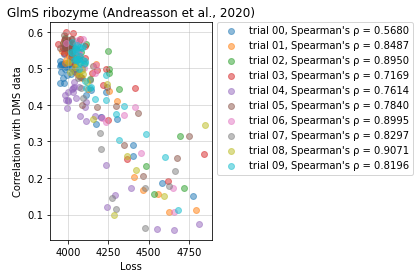

In [12]:
for i in range(10):
    df_tmp = d_trial[i].dropna(axis = 0)
    corr, p = spearmanr(df_tmp["elbo_valid"], df_tmp["Spearman's ρ"])

    plt.scatter(
        df_tmp["elbo_valid"],
        df_tmp["Spearman's ρ"].abs(), alpha = 0.5, label = f"trial {str(i).zfill(2)}, Spearman's ρ = {corr:.4f}")
plt.grid(alpha = 0.5)
plt.legend(loc = (1.03, 0.3))
plt.xlabel("Loss")
plt.ylabel("Correlation with DMS data")
plt.title("GlmS ribozyme (Andreasson et al., 2020)")
plt.subplots_adjust(right = 0.5)

# plt.savefig("../../outputs/figures/suppfig_dmspred_and_loss_glms.pdf", transparent = True)